In [1]:
#%pip install numpy pandas scikit-learn nltk spacy mlflow chardet

# 1. Introduction et Contexte
Objectif : Expliquer brièvement le contexte du projet et les objectifs.

Problématique : Décrire le problème de catégorisation de texte et les défis associés.

Approche globale : Présenter les grandes étapes du projet (exploration, prétraitement, modélisation, évaluation).

In [2]:
# Imports standards de Python
import os
import re
import string
import time
from collections import Counter
import warnings

# Imports de bibliothèques tierces
import chardet
import mlflow
import mlflow.sklearn
import nltk
import numpy as np
import pandas as pd
import spacy

# Imports de NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Imports de scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Imports de MLflow
from mlflow.models.signature import infer_signature

# Téléchargements NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Chargement du modèle spaCy
#nlp = spacy.load("en_core_web_sm")

# Configuration globale
notebook_path = "tp2.ipynb"  
perc_selection_lignes = 100  # Pourcentage de lignes à sélectionner aléatoirement

warnings.filterwarnings("ignore", category=UserWarning, module="mlflow")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claudia.abad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Chargement des données
Lecture des fichiers texte :

In [3]:
def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        raw_data = f.read()
    result = chardet.detect(raw_data)
    return result["encoding"]

def generer_dataset(dossier_principal: str = 'bbcsport'):
    df = pd.DataFrame(columns=["sport", "text"])

    for nom_dossier in os.listdir(dossier_principal):
        chemin_dossier = os.path.join(dossier_principal, nom_dossier)
        
        if os.path.isdir(chemin_dossier):
            for nom_fichier in os.listdir(chemin_dossier):
                chemin_fichier = os.path.join(chemin_dossier, nom_fichier)
                
                if nom_fichier.endswith(".txt"):
                    encoding = detect_encoding(chemin_fichier)
                    with open(chemin_fichier, "r", encoding=encoding) as fichier:
                        contenu = fichier.read()
                    
                    nouvelle_ligne = {"sport": nom_dossier, "text": contenu}
                    df = pd.concat([df, pd.DataFrame([nouvelle_ligne])], ignore_index=True)

    return df

df = generer_dataset()

perc_selection_lignes=20

df = df.sample(frac=1, random_state=11)
    
df

,sport,text
545,rugby,Lewsey puzzle over disallowed try\n\nEngland's...
413,athletics,McIlroy continues winning streak\n\nJames McIl...
599,rugby,Captains lining up for Aid match\n\nIreland's ...
457,athletics,Holmes is hit by hamstring injury\n\nKelly Hol...
464,athletics,Greene to compete in Birmingham\n\nMaurice Gre...
...,...,...
269,cricket,Shoaib ruled out of Test series\n\nFast bowler...
337,cricket,Harbhajan action given all-clear\n\nIndian spi...
91,football,Benitez deflects blame from Dudek\n\nLiverpool...
80,football,England's defensive crisis grows\n\nEngland's ...


# 3 . Analyse Exploratoire de données

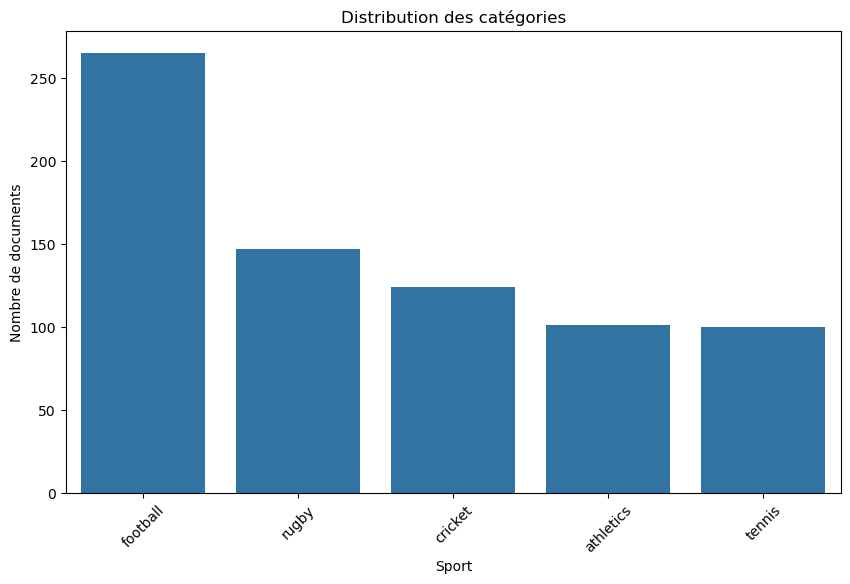

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sport', order=df['sport'].value_counts().index)
plt.title('Distribution des catégories')
plt.xlabel('Sport')
plt.ylabel('Nombre de documents')
plt.xticks(rotation=45)
plt.show()

# 4 . Prétraitement des données
Nettoyage du texte :

* Supprimer la ponctuation, les stopwords, les caractères spéciaux.

* Convertir le texte en minuscules.

* Lemmatisation

In [5]:
stop_words = set(stopwords.words('english'))
    
def nettoyer_texte(df, colonne_texte):
    
    def nettoyer_texte_unique(texte):
        texte = re.sub(r'[^\w\s]', '', texte)  # Supprimer la ponctuation
        texte = texte.lower()  # Convertir en minuscules
        tokens = word_tokenize(texte)  # Tokenisation
        tokens = [token for token in tokens if token not in stop_words]  # Supprimer les stopwords
        return ' '.join(tokens)
    
    df['texte_nettoye'] = df[colonne_texte].apply(nettoyer_texte_unique)
    return df

df = nettoyer_texte(df, "text")

df


,sport,text,texte_nettoye
545,rugby,Lewsey puzzle over disallowed try\n\nEngland's...,lewsey puzzle disallowed try englands josh lew...
413,athletics,McIlroy continues winning streak\n\nJames McIl...,mcilroy continues winning streak james mcilroy...
599,rugby,Captains lining up for Aid match\n\nIreland's ...,captains lining aid match irelands brian odris...
457,athletics,Holmes is hit by hamstring injury\n\nKelly Hol...,holmes hit hamstring injury kelly holmes force...
464,athletics,Greene to compete in Birmingham\n\nMaurice Gre...,greene compete birmingham maurice greene go he...
...,...,...,...
269,cricket,Shoaib ruled out of Test series\n\nFast bowler...,shoaib ruled test series fast bowler shoaib ak...
337,cricket,Harbhajan action given all-clear\n\nIndian spi...,harbhajan action given allclear indian spinner...
91,football,Benitez deflects blame from Dudek\n\nLiverpool...,benitez deflects blame dudek liverpool manager...
80,football,England's defensive crisis grows\n\nEngland's ...,englands defensive crisis grows englands defen...


# Extraction de features



In [6]:
def calculer_entropie(text):
    mots = text.split()
    compteur = Counter(mots)
    probas = [freq / len(mots) for freq in compteur.values()]
    return -np.sum(probas * np.log2(probas))

def extrair_features(df: pd.DataFrame) -> pd.DataFrame:
    df["num_lignes"] = df["text"].map(lambda text: text.count("\n\n"))  
    df["text"] = df["text"].map(lambda text: text.replace("\n\n", " "))

    df['longueur_texte'] = df['text'].apply(len)
    df['num_mots'] = df['text'].map(lambda x: len(x.split()))
    df['num_caracteres_avec_espaces'] = df['text'].map(lambda x: len(x))
    df['longueur_moyenne_mots'] = df['text'].map(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
    df['stopwords'] = df['text'].map(lambda x: len([z for z in x.split() if z in stop_words]))
    df['mots_chiffres'] = df['text'].map(lambda x: len([z for z in x.split() if z.isdigit()]))
    df['entropie'] = df['text'].apply(calculer_entropie)
    df['richesse_lexicale'] = df['text'].apply(lambda x: len(set(x.split())) / len(x.split()))
    df['mots_uniques'] = df['text'].apply(lambda x: len(set(x.split())))
    df['nombre_majuscules'] = df['text'].apply(lambda x: sum(1 for mot in x.split() if mot.istitle()))
    df['nombre_ponctuations'] = df['text'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

    return df

df = extrair_features(df)

df[["text", "texte_nettoye", "num_lignes"]]

,text,texte_nettoye,num_lignes
545,Lewsey puzzle over disallowed try England's Jo...,lewsey puzzle disallowed try englands josh lew...,3
413,McIlroy continues winning streak James McIlroy...,mcilroy continues winning streak james mcilroy...,2
599,Captains lining up for Aid match Ireland's Bri...,captains lining aid match irelands brian odris...,4
457,Holmes is hit by hamstring injury Kelly Holmes...,holmes hit hamstring injury kelly holmes force...,3
464,Greene to compete in Birmingham Maurice Greene...,greene compete birmingham maurice greene go he...,3
...,...,...,...
269,Shoaib ruled out of Test series Fast bowler Sh...,shoaib ruled test series fast bowler shoaib ak...,3
337,Harbhajan action given all-clear Indian spinne...,harbhajan action given allclear indian spinner...,2
91,Benitez deflects blame from Dudek Liverpool ma...,benitez deflects blame dudek liverpool manager...,2
80,England's defensive crisis grows England's def...,englands defensive crisis grows englands defen...,3


In [7]:
def apply_stemming(df, text_column, new_column_name="stemmed_text"):
    stemmer = PorterStemmer()
    
    def stem_text(text):
        tokens = word_tokenize(text)  # Tokenisation du texte
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stemming
        return " ".join(stemmed_tokens)  # Rejoindre les tokens en une chaîne
    
    df[new_column_name] = df[text_column].apply(stem_text)
    return df

def apply_lemmatization_nltk(df, text_column, new_column_name="lemmatized_text"):
    
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize_text(text):
        tokens = word_tokenize(text)  # Tokenisation du texte
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatisation
        return " ".join(lemmatized_tokens)  # Rejoindre les tokens en une chaîne
    
    df[new_column_name] = df[text_column].apply(lemmatize_text)
    return df

# Appliquer le stemming
df = apply_stemming(df, text_column="texte_nettoye", new_column_name="Stemmed_Text")

# Appliquer la lemmatisation avec NLTK
df = apply_lemmatization_nltk(df, text_column="texte_nettoye", new_column_name="Lemmatized_Text_NLTK")

df


,sport,text,texte_nettoye,num_lignes,longueur_texte,num_mots,num_caracteres_avec_espaces,longueur_moyenne_mots,stopwords,mots_chiffres,entropie,richesse_lexicale,mots_uniques,nombre_majuscules,nombre_ponctuations,Stemmed_Text,Lemmatized_Text_NLTK
545,rugby,Lewsey puzzle over disallowed try England's Jo...,lewsey puzzle disallowed try englands josh lew...,3,1224,227,1224,4.392070,93,0,6.834080,0.660793,150,34,46,lewsey puzzl disallow tri england josh lewsey ...,lewsey puzzle disallowed try england josh lews...
413,athletics,McIlroy continues winning streak James McIlroy...,mcilroy continues winning streak james mcilroy...,2,1222,203,1222,5.019704,70,0,6.863443,0.709360,144,26,34,mcilroy continu win streak jame mcilroy storm ...,mcilroy continues winning streak james mcilroy...
599,rugby,Captains lining up for Aid match Ireland's Bri...,captains lining aid match irelands brian odris...,4,1823,298,1823,5.117450,55,1,7.388641,0.667785,199,180,158,captain line aid match ireland brian odriscol ...,captain lining aid match ireland brian odrisco...
457,athletics,Holmes is hit by hamstring injury Kelly Holmes...,holmes hit hamstring injury kelly holmes force...,3,1413,256,1413,4.519531,115,1,7.045083,0.652344,167,42,31,holm hit hamstr injuri kelli holm forc weekend...,holmes hit hamstring injury kelly holmes force...
464,athletics,Greene to compete in Birmingham Maurice Greene...,greene compete birmingham maurice greene go he...,3,961,159,961,5.044025,51,1,6.499336,0.716981,114,37,29,green compet birmingham mauric green go headto...,greene compete birmingham maurice greene go he...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,cricket,Shoaib ruled out of Test series Fast bowler Sh...,shoaib ruled test series fast bowler shoaib ak...,3,2358,414,2358,4.695652,172,4,7.317432,0.570048,236,61,51,shoaib rule test seri fast bowler shoaib akhta...,shoaib ruled test series fast bowler shoaib ak...
337,cricket,Harbhajan action given all-clear Indian spinne...,harbhajan action given allclear indian spinner...,2,1377,230,1377,4.986957,94,3,6.938650,0.678261,156,31,31,harbhajan action given allclear indian spinner...,harbhajan action given allclear indian spinner...
91,football,Benitez deflects blame from Dudek Liverpool ma...,benitez deflects blame dudek liverpool manager...,2,1073,191,1073,4.617801,87,0,6.745524,0.670157,128,32,32,benitez deflect blame dudek liverpool manag ra...,benitez deflects blame dudek liverpool manager...
80,football,England's defensive crisis grows England's def...,englands defensive crisis grows englands defen...,3,1328,221,1328,5.009050,90,0,6.915576,0.674208,149,48,29,england defens crisi grow england defens worri...,england defensive crisis grows england defensi...


Remarques
Stemming : Moins précis que la lemmatisation, mais plus rapide.

Lemmatisation : Plus précis, mais nécessite des ressources supplémentaires (comme un modèle de langue pour spaCy).

#### **3. Exploration des données**
- **Statistiques descriptives** :
  - Nombre total de documents.
  - Longueur moyenne des textes par catégorie.
  - Distribution des catégories (visualisation avec Matplotlib/Seaborn).
- **Analyse textuelle** :
  - Fréquence des mots par catégorie (utiliser `TextHero` ou `CountVectorizer`).
  - Nuages de mots (`wordcloud`) pour chaque catégorie.

In [8]:
total_documents = df.shape[0]
print(f"Nombre total de documents : {total_documents}")

Nombre total de documents : 737


In [9]:
df_numerique = df.select_dtypes(include=['int64', 'float64'])
df_pivot = df_numerique.pivot_table(index=df['sport'], aggfunc='mean')
df_pivot

,entropie,longueur_moyenne_mots,longueur_texte,mots_chiffres,mots_uniques,nombre_majuscules,nombre_ponctuations,num_caracteres_avec_espaces,num_lignes,num_mots,richesse_lexicale,stopwords
sport,,,,,,,,,,,,
athletics,7.008751,4.858474,1805.267327,1.514851,190.237624,53.188119,49.405941,1805.267327,4.059406,310.069307,0.650318,120.871287
cricket,7.348756,4.829364,2199.927419,4.879032,235.201613,79.282258,68.250000,2199.927419,5.411290,380.112903,0.645292,139.064516
football,7.128990,4.737688,1955.830189,1.513208,205.784906,61.581132,57.735849,1955.830189,4.449057,342.630189,0.631975,137.932075
rugby,7.285335,4.824184,2118.884354,1.993197,225.115646,81.428571,71.387755,2118.884354,4.727891,365.707483,0.639004,137.809524
tennis,6.993732,4.652581,1602.910000,2.090000,178.570000,52.130000,53.730000,1602.910000,4.000000,284.490000,0.661154,106.770000


---

### **1. Entropie**
- Le **cricket** a l'entropie la plus élevée (7.348756), ce qui suggère une plus grande diversité lexicale ou une plus grande complexité dans les textes associés à ce sport.
- Le **tennis** a l'entropie la plus faible (6.993732), indiquant une moindre diversité lexicale ou une structure textuelle plus simple.

---

### **2. Longueur moyenne des mots**
- Les mots dans les textes liés à l'**athletics** sont en moyenne les plus longs (4.858474), tandis que ceux du **tennis** sont les plus courts (4.652581).
- Cela pourrait indiquer que les textes sur l'athletics utilisent des termes plus techniques ou spécifiques.

---

### **3. Longueur du texte**
- Les textes sur le **cricket** sont les plus longs (2199.927419), suivis de près par le **rugby** (2118.884354).
- Les textes sur le **tennis** sont les plus courts (1602.910000), ce qui pourrait indiquer des descriptions plus concises ou moins détaillées.

---

### **4. Mots chiffres**
- Le **cricket** utilise beaucoup plus de mots chiffres (4.879032), ce qui pourrait refléter l'importance des statistiques (comme les scores, les moyennes, etc.) dans les textes liés à ce sport.
- L'**athletics** et le **football** en utilisent très peu, ce qui suggère que les textes sont moins axés sur les données numériques.

---

### **5. Mots uniques**
- Le **cricket** et le **rugby** ont le plus grand nombre de mots uniques, ce qui confirme une plus grande diversité lexicale.
- Le **tennis** a le moins de mots uniques, ce qui pourrait indiquer un vocabulaire plus restreint ou répétitif.

---

### **6. Nombre de majuscules**
- Le **rugby** et le **cricket** utilisent beaucoup plus de majuscules, ce qui pourrait être dû à l'utilisation fréquente de noms propres (équipes, joueurs, lieux).
- L'**athletics** et le **tennis** en utilisent moins, ce qui pourrait refléter une moindre importance des noms propres.

---

### **7. Nombre de ponctuations**
- Le **rugby** et le **cricket** utilisent plus de ponctuation, ce qui pourrait indiquer des textes plus structurés ou complexes.
- L'**athletics** et le **tennis** en utilisent moins, ce qui pourrait refléter des textes plus simples ou moins formels.

---

### **8. Nombre de caractères (avec espaces)**
- Similaire à la longueur du texte, le **cricket** et le **rugby** ont les textes les plus longs en termes de caractères.
- Le **tennis** a les textes les plus courts.

---

### **9. Nombre de lignes**
- Le **cricket** a le plus grand nombre de lignes par texte, ce qui confirme que les textes sont plus longs et détaillés.
- Le **tennis** a le moins de lignes, ce qui correspond à des textes plus courts.

---

### **10. Nombre de mots**
- Le **cricket** et le **rugby** ont le plus grand nombre de mots, ce qui confirme que leurs textes sont plus longs.
- Le **tennis** a le moins de mots, ce qui correspond à des textes plus courts.

---

### **11. Richesse lexicale**
- Le **tennis** a la richesse lexicale la plus élevée (0.661154), ce qui signifie que les textes utilisent un vocabulaire plus varié par rapport au nombre total de mots.
- Le **football** a la richesse lexicale la plus faible (0.631975), ce qui pourrait indiquer une répétition plus fréquente des mots.

---

### **12. Stopwords**
- Le **cricket** et le **football** utilisent le plus de stopwords, ce qui pourrait indiquer des textes plus descriptifs ou conversationnels.
- Le **tennis** en utilise le moins, ce qui pourrait refléter des textes plus techniques ou concis.

---

### **Synthèse**
- **Cricket** et **Rugby** : Textes plus longs, plus complexes, avec une utilisation importante de majuscules, de ponctuation et de mots chiffres. Cela pourrait refléter des descriptions détaillées, des statistiques ou des analyses.
- **Tennis** : Textes plus courts, moins de diversité lexicale, mais une richesse lexicale plus élevée. Cela pourrait indiquer des descriptions plus techniques ou spécialisées.
- **Athletics** et **Football** : Situés entre les deux, avec des textes de longueur moyenne et une utilisation modérée des caractéristiques analysées.


---

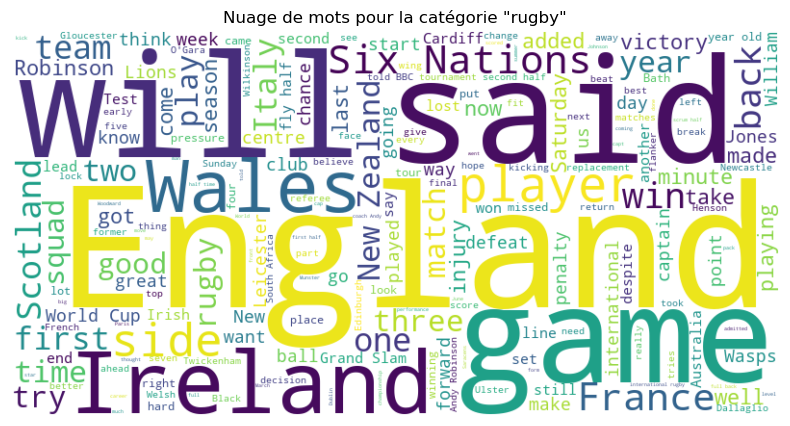

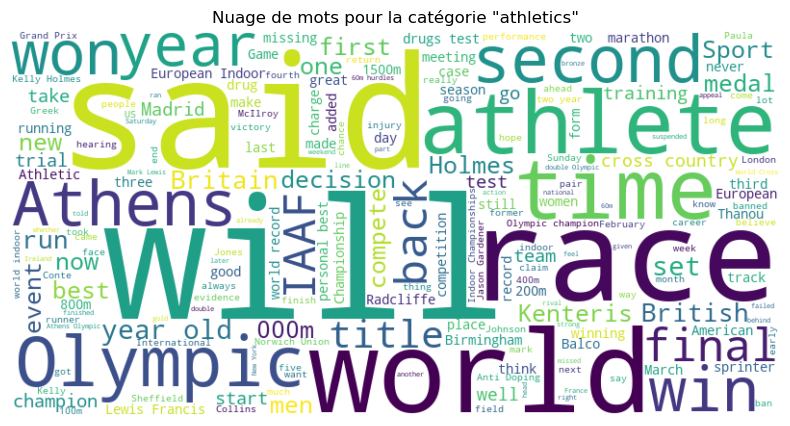

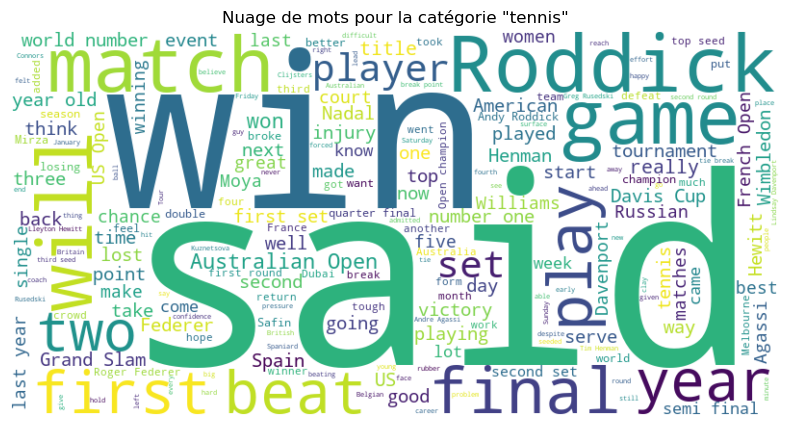

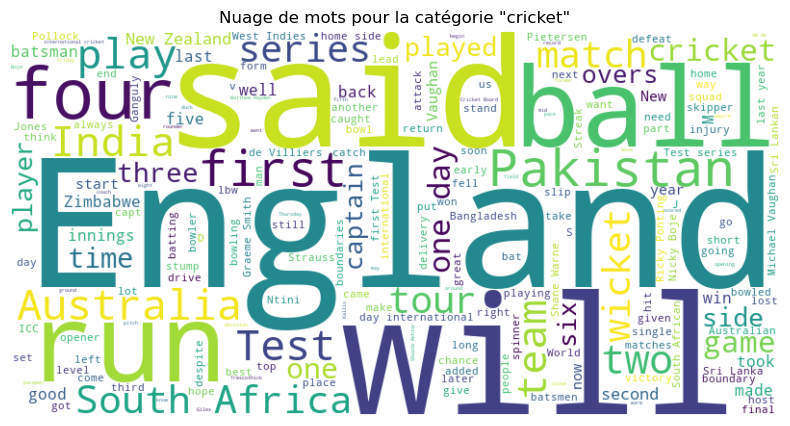

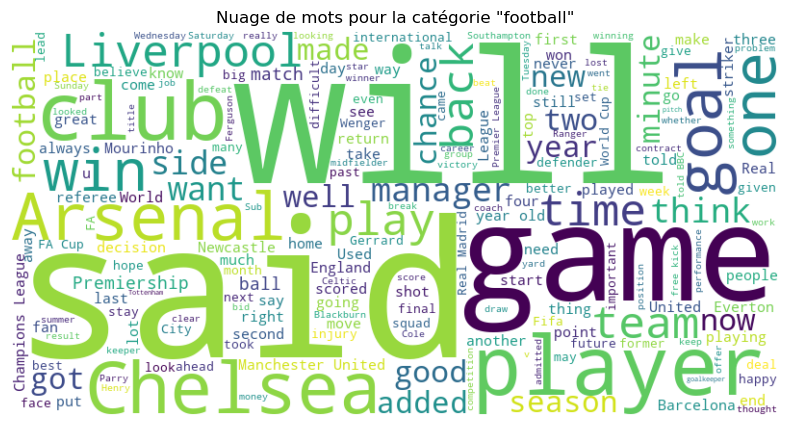

In [10]:
from wordcloud import WordCloud

# Générer un nuage de mots pour chaque catégorie
for category in df['sport'].unique():
    texts = " ".join(df[df['sport'] == category]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots pour la catégorie "{category}"')
    plt.axis('off')
    plt.show()

#### **5. Modélisation**

##### Approche 1

Ce code utilise une technique d'extraction de caractéristiques textuelles (TF-IDF Vectors) et applique quatre algorithmes de classification différents : Naive Bayes, Complement Naive Bayes, Régression Logistique et SVM. L'objectif est de comparer les performances de ces modèles en se basant sur la même technique d'extraction. Les étapes principales sont :

1. **Extraction des Caractéristiques** :  
   - Le texte est transformé en vecteurs TF-IDF.  

2. **Classification** :  
   - Quatre modèles sont entraînés et évalués : Naive Bayes, Complement Naive Bayes, Régression Logistique et SVM.  

3. **Comparaison** :  
   - Les performances des modèles sont comparées en utilisant des métriques comme le score F1 et les temps d'exécution.  

En résumé, ce code permet de comparer trois modèles de classification en utilisant une technique d'extraction commune (TF-IDF).

In [11]:
def pretraiter_donnees(nom_modele, X_train, X_test, colonne_texte):
    if nom_modele in ["Naive Bayes", "Complement Naive Bayes", "Régression Logistique", "SVM"]:
        preprocesseur = ColumnTransformer(
            transformers=[
                ('texte', TfidfVectorizer(), colonne_texte)
            ]
        )
    else:
        raise ValueError(f"Modèle inconnu : {nom_modele}")

    X_train_pretraite = preprocesseur.fit_transform(X_train)
    X_test_pretraite = preprocesseur.transform(X_test)
    return X_train_pretraite, X_test_pretraite, preprocesseur

def evaluer_modele(nom, modele, X_train, X_test, y_train, y_test, colonne_texte):
    with mlflow.start_run(run_name=nom, nested=True):
        X_train_pretraite, X_test_pretraite, preprocesseur = pretraiter_donnees(nom, X_train, X_test, colonne_texte)

        debut_entrainement = time.time()
        modele.fit(X_train_pretraite, y_train)
        temps_entrainement = time.time() - debut_entrainement

        scores_cv = cross_val_score(modele, X_train_pretraite, y_train, cv=5, scoring='f1_weighted')
        f1_moyen_cv = scores_cv.mean()

        debut_prediction = time.time()
        y_pred = modele.predict(X_test_pretraite)
        temps_prediction = time.time() - debut_prediction

        f1_test = f1_score(y_test, y_pred, average='weighted')

        print(f"\n{nom} - Rapport de classification :")
        print(classification_report(y_test, y_pred, zero_division=0))

        mlflow.log_metric("F1_Score_Test", f1_test)
        mlflow.log_metric("F1_Score_CV", f1_moyen_cv)
        mlflow.log_metric("Temps_entrainement_s", temps_entrainement)
        mlflow.log_metric("Temps_prediction_s", temps_prediction)

        mlflow.log_param("n_lignes_dataset", df.shape[0])
        mlflow.log_param("n_lignes_entrainement", X_train.shape[0])
        mlflow.log_param("n_lignes_test", X_test.shape[0])
        mlflow.log_param("pourcentage_selection_lignes", perc_selection_lignes)
        mlflow.log_param("mlflow.note.content", "Approche 1 - TF-IDF Vectors avec 4 modèles de classification")

        mlflow.log_artifact(notebook_path, "notebook")
        mlflow.log_table(data= df, artifact_file="df_avec_caracteristics.json")
    
        signature = infer_signature(X_train, y_train)
        mlflow.sklearn.log_model(modele, nom, signature=signature)

        return {
            "F1 (Test)": f1_test,
            "F1 (CV)": f1_moyen_cv,
            "Temps d'entraînement (s)": temps_entrainement,
            "Temps de prédiction (s)": temps_prediction
        }

# Colonnes de données
colonne_texte = 'Stemmed_Text'

# Modèles à évaluer
modeles = {
    "Naive Bayes": MultinomialNB(),
    "Complement Naive Bayes": ComplementNB(),
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear')
}

# Séparation des données
X = df.drop(['sport'], axis=1)
y = df['sport']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Évaluation des modèles
mlflow.set_experiment("Approche 1 - TF-IDF Vectors avec 4 modèles de classification")
resultats = {}
for nom, modele in modeles.items():
    resultats[nom] = evaluer_modele(nom, modele, X_train, X_test, y_train, y_test, colonne_texte)

# Affichage des résultats
resultats_df = pd.DataFrame(resultats).T
print("\nComparaison des modèles :")
print(resultats_df)


2025/03/04 21:16:59 INFO mlflow.tracking.fluent: Experiment with name 'Approche 1 - TF-IDF Vectors avec 4 modèles de classification' does not exist. Creating a new experiment.



Naive Bayes - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      0.70      0.82        20
     cricket       1.00      0.96      0.98        25
    football       0.72      1.00      0.83        53
       rugby       1.00      0.77      0.87        30
      tennis       1.00      0.65      0.79        20

    accuracy                           0.86       148
   macro avg       0.94      0.82      0.86       148
weighted avg       0.90      0.86      0.86       148


Complement Naive Bayes - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      0.95      0.97        20
     cricket       1.00      1.00      1.00        25
    football       0.98      1.00      0.99        53
       rugby       1.00      1.00      1.00        30
      tennis       1.00      1.00      1.00        20

    accuracy                           0.99       148
   macro avg       1.00      0.99 

### Approche 2 - ComplementNB avec 4 sources de données

Ce code applique le modèle **Complement Naive Bayes** sur quatre types de sources de données pour comparer leurs performances. Les étapes principales sont :

1. **Sources de Données** :
   - **Colonnes Numériques** : Utilisation des caractéristiques numériques normalisées avec `MinMaxScaler`.
   - **Word Count Vectors** : Transformation du texte en vecteurs de comptage de mots avec `CountVectorizer`.
   - **TF-IDF Vectors** : Transformation du texte en vecteurs TF-IDF avec `TfidfVectorizer`.
   - **Word Embeddings** : Utilisation des embeddings de mots générés par spaCy, normalisés avec `MinMaxScaler`.

2. **Évaluation** :
   - Chaque source est évaluée avec **ComplementNB** en utilisant la validation croisée et le score F1 pondéré.
   - Les résultats (F1 Score, temps d'exécution) sont enregistrés dans **MLflow** pour comparaison.

3. **Résultats** :
   - Les performances sont comparées pour chaque source, avec un focus sur le score F1 et les temps d'entraînement/prédiction.

En résumé, ce code permet de comparer l'efficacité de différentes techniques d'extraction de caractéristiques avec **ComplementNB**.

In [12]:
# Colonnes numériques
colonnes_numeriques = [
    "entropie", "longueur_moyenne_mots", "longueur_texte", "mots_chiffres",
    "mots_uniques", "nombre_majuscules", "nombre_ponctuations",
    "num_caracteres_avec_espaces", "num_lignes", "num_mots",
    "richesse_lexicale", "stopwords"
]

# Colonne de texte
colonne_texte = "Stemmed_Text"

# Séparation des données
X = df.drop(columns=["sport"])  # Caractéristiques
y = df["sport"]  # Étiquettes

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fonction pour évaluer et enregistrer les résultats
def evaluer_modele(nom_source, X_train, X_test, y_train, y_test, preprocesseur):
    with mlflow.start_run(run_name=f"ComplementNB_{nom_source}"):
        # Créer le pipeline
        modele = ComplementNB()
        pipeline = Pipeline(steps=[
            ("preprocesseur", preprocesseur),
            ("modele", modele)
        ])

        # Entraînement du modèle
        debut_entrainement = time.time()
        pipeline.fit(X_train, y_train)
        temps_entrainement = time.time() - debut_entrainement

        # Validation croisée
        scores_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1_weighted")
        f1_moyen_cv = scores_cv.mean()

        # Prédiction sur l'ensemble de test
        debut_prediction = time.time()
        y_pred = pipeline.predict(X_test)
        temps_prediction = time.time() - debut_prediction

        # Calcul du score F1 sur l'ensemble de test
        f1_test = f1_score(y_test, y_pred, average="weighted")

        # Affichage des résultats
        print(f"\nRésultats pour {nom_source}:")
        print(f"F1 Score (Test): {f1_test}")
        print(f"F1 Score (CV): {f1_moyen_cv}")
        print(f"Temps d'entraînement (s): {temps_entrainement}")
        print(f"Temps de prédiction (s): {temps_prediction}")
        print("\nRapport de classification :")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Enregistrement des métriques dans MLflow
        mlflow.log_metric("F1_Score_Test", f1_test)
        mlflow.log_metric("F1_Score_CV", f1_moyen_cv)
        mlflow.log_metric("Temps_entrainement_s", temps_entrainement)
        mlflow.log_metric("Temps_prediction_s", temps_prediction)

        mlflow.log_param("n_lignes_dataset", df.shape[0])
        mlflow.log_param("n_lignes_entrainement", X_train.shape[0])
        mlflow.log_param("n_lignes_test", X_test.shape[0])
        mlflow.log_param("pourcentage_selection_lignes", perc_selection_lignes)
        mlflow.log_param("mlflow.note.content", "Approche 2 - ComplementNB avec 4 sources de données")

        mlflow.log_artifact(notebook_path, "notebook")
        mlflow.log_table(data= df, artifact_file="df_avec_caracteristics.json")
    

        # Enregistrement du modèle dans MLflow
        signature = infer_signature(X_train, y_train)
        mlflow.sklearn.log_model(pipeline, nom_source, signature=signature)

mlflow.set_experiment("Approche 2 - ComplementNB avec 4 sources de données")
# 1. Source : Colonnes numériques
# ComplementNB n'accepte que des valeurs positives, 
# a cause de la nature de la distribution de nos données, 
# on va utiliser MinMaxScaler, entre 0 et 1
preprocesseur_numerique = ColumnTransformer(
    transformers=[
        ("numeriques", MinMaxScaler(), colonnes_numeriques)
    ]
)

evaluer_modele("Colonnes_Numeriques", X_train, X_test, y_train, y_test, preprocesseur_numerique)

# 2. Source : Word Count Vectors
preprocesseur_word_count = ColumnTransformer(
    transformers=[
        ("texte", CountVectorizer(), colonne_texte)
    ]
)
evaluer_modele("Word_Count_Vectors", X_train, X_test, y_train, y_test, preprocesseur_word_count)

# 3. Source : TF-IDF Vectors
preprocesseur_tfidf = ColumnTransformer(
    transformers=[
        ("texte", TfidfVectorizer(), colonne_texte)
    ]
)
evaluer_modele("TFIDF_Vectors", X_train, X_test, y_train, y_test, preprocesseur_tfidf)

# 4. Source : Word Embeddings (exemple avec un modèle pré-entraîné comme Word2Vec)

# Transformer le texte en embeddings avec MinMaxScaler
class SpacyEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp_model):
        self.nlp_model = nlp_model
        self.scaler = MinMaxScaler()  # Ajouter un scaler pour normaliser entre 0 et 1

    def transform(self, X, y=None):
        embeddings = np.array([np.mean([token.vector for token in self.nlp_model(text)], axis=0) for text in X])
        return self.scaler.fit_transform(embeddings)  # Appliquer MinMaxScaler

    def fit(self, X, y=None):
        return self

# Appliquer le transformateur
preprocesseur_word_embeddings = ColumnTransformer(
    transformers=[
        ("texte", SpacyEmbeddingTransformer(nlp), colonne_texte)
    ]
)

# Évaluer le modèle
evaluer_modele("Word_Embeddings_spaCy", X_train, X_test, y_train, y_test, preprocesseur_word_embeddings)

2025/03/04 21:17:14 INFO mlflow.tracking.fluent: Experiment with name 'Approche 2 - ComplementNB avec 4 sources de données' does not exist. Creating a new experiment.



Résultats pour Colonnes_Numeriques:
F1 Score (Test): 0.28051115487864386
F1 Score (CV): 0.3293574308679182
Temps d'entraînement (s): 0.0058019161224365234
Temps de prédiction (s): 0.001360177993774414

Rapport de classification :
              precision    recall  f1-score   support

   athletics       0.19      0.50      0.28        20
     cricket       0.47      0.36      0.41        25
    football       0.39      0.21      0.27        53
       rugby       0.18      0.23      0.21        30
      tennis       0.36      0.20      0.26        20

    accuracy                           0.28       148
   macro avg       0.32      0.30      0.28       148
weighted avg       0.33      0.28      0.28       148


Résultats pour Word_Count_Vectors:
F1 Score (Test): 0.9932773109243698
F1 Score (CV): 0.994907215621466
Temps d'entraînement (s): 0.0663762092590332
Temps de prédiction (s): 0.013568878173828125

Rapport de classification :
              precision    recall  f1-score   support



NameError: name 'nlp' is not defined

In [ ]:
#!mlflow ui